In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import tensorflow
import glob
import tqdm

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [8]:
train_normal = glob.glob('/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/train/NORMAL/*.jpeg') 
a = len(train_normal)
a

1349

In [9]:
train_pneumonia = glob.glob('/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/train/PNEUMONIA/*.jpeg')
b = len(train_pneumonia)
b

3883

In [10]:
# Total training images

print("Total nos. of training images are: {}".format(a + b))

Total nos. of training images are: 5232


In [11]:
#Data Augmentation

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [12]:
train_dataset = train_datagen.flow_from_directory(directory = '/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/train/',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'training',
                                                  batch_size = 64)

Found 4187 images belonging to 2 classes.


In [13]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1045 images belonging to 2 classes.


In [14]:
# Checking Indices

train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
len(train_dataset)


66

100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


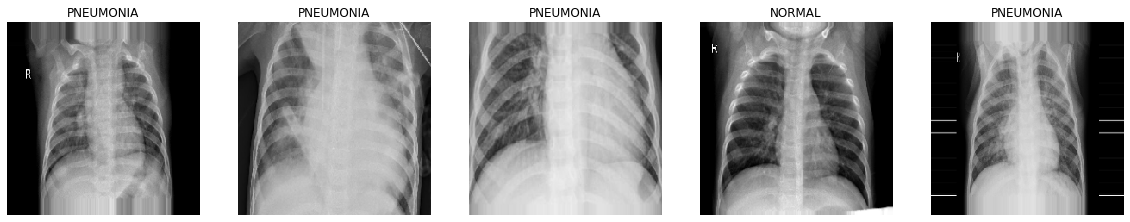

In [16]:
# Viewing Images 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('PNEUMONIA')
    else:
        ax[i].set_title('NORMAL')

In [17]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [18]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [19]:
# Summary

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [21]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [22]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [23]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 3,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [25]:
# Model Fitting 

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 5,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/5
66/66 [==============================] - ETA: 0s - loss: 0.2038 - auc: 0.9681 
Epoch 00001: val_auc improved from -inf to 0.98514, saving model to ./best_weights.hdf5
66/66 [==============================] - 2246s 34s/step - loss: 0.2038 - auc: 0.9681 - val_loss: 0.1522 - val_auc: 0.9851
Epoch 2/5
66/66 [==============================] - ETA: 0s - loss: 0.1450 - auc: 0.9833 
Epoch 00002: val_auc did not improve from 0.98514
66/66 [==============================] - 1951s 30s/step - loss: 0.1450 - auc: 0.9833 - val_loss: 0.1451 - val_auc: 0.9842
Epoch 3/5
66/66 [==============================] - ETA: 0s - loss: 0.1245 - auc: 0.9866 
Epoch 00003: val_auc improved from 0.98514 to 0.98846, saving model to ./best_weights.hdf5
66/66 [==============================] - 1898s 29s/step - loss: 0.1245 - auc: 0.9866 - val_loss: 0.1250 - val_auc: 0.9885
Epoch 4/5
66/66 [==============================] - ETA: 0s - loss: 0.1007 - auc: 0.9916 
Epoch 00004: val_auc improved from 0.98846 to 0.9

## Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

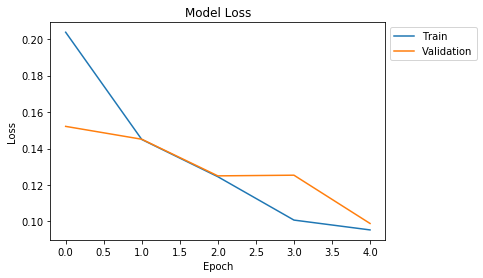

In [32]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

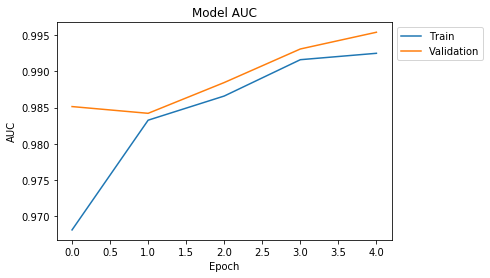

In [31]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [27]:
# Test Data 

test_dataset = test_datagen.flow_from_directory(directory = '/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/test',
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                batch_size = 64)

Found 624 images belonging to 2 classes.


In [28]:
# Evaluating Loss and AUC - Test Data 

model.evaluate(test_dataset)

10/10 [==============================] - 178s 18s/step - loss: 0.1722 - auc: 0.9816


[0.17223021388053894, 0.9816403985023499]

Instructions for updating:
Please use `model.predict()` instead.
Pasien Normal


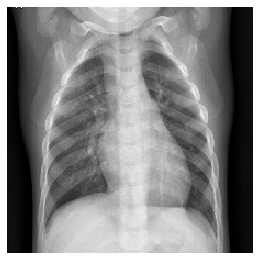

In [29]:
# Test Case 1: NORMAL

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/test/NORMAL/NORMAL-1212407-0001.jpeg', target_size=(224,224))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("Pasien Terkena Pneumonia")
else:
    print("Pasien Normal")

Pasien Terkena Pneumonia


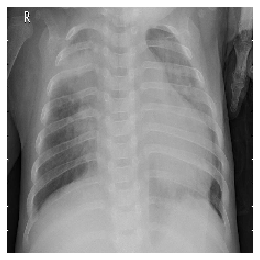

In [30]:
# Test Case 1: NORMAL

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/Users/nezarabdilahprakasa/Desktop/Xray-data/chest_xray/test/PNEUMONIA/BACTERIA-1220485-0001.jpeg', target_size=(224,224))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("Pasien Terkena Pneumonia")
else:
    print("Pasien Normal")